In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
from pathlib import Path
import sys
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold # Import KFold

# Define project root based on notebook location (assuming this part is correct for your setup)
def find_project_root(current: Path, marker: str = ".git"):
    for parent in current.resolve().parents:
        if (parent / marker).exists():
            return parent
    return current.resolve() # fallback

PROJECT_ROOT = find_project_root(Path.cwd())
RAW_DIR = PROJECT_ROOT / "data" / "raw"
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
EXTERNAL_DIR = PROJECT_ROOT / "data" / "external"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
MODELS_DIR = PROJECT_ROOT / "models"
TABLES_DIR = REPORTS_DIR / "tables"

# Load the data once outside the train function for efficiency in a sweep
df = pd.read_csv(PROCESSED_DIR /"monthly_dengue_env_id.csv")

# --- REGION REASSIGNMENT (Keep this for consistency, but it won't be used for grouping) ---
df['Region_Group'] = df['Region'].replace({'Maluku Islands': 'Maluku-Papua', 'Papua': 'Maluku-Papua'})
print("--- DataFrame after Region_Group creation ---")
print(df['Region_Group'].value_counts())
print("-" * 50)

df['YearMonth'] = pd.to_datetime(df['YearMonth']) # Ensure YearMonth is datetime

# Define variable categories
env_vars = [
    'temperature_2m', 'temperature_2m_min', 'temperature_2m_max',
    'precipitation', 'potential_evaporation_sum', 'total_evaporation_sum',
    'evaporative_stress_index', 'aridity_index',
    'temperature_2m_ANOM', 'temperature_2m_min_ANOM', 'temperature_2m_max_ANOM',
    'potential_evaporation_sum_ANOM', 'total_evaporation_sum_ANOM', 'precipitation_ANOM'
]

land_use_vars = [
    'Class_70', 'Class_60', 'Class_50', 'Class_40', 'Class_95',
    'Class_30', 'Class_20', 'Class_10', 'Class_90', 'Class_80'
]

climate_vars = ['ANOM1+2', 'ANOM3', 'ANOM4', 'ANOM3.4', 'DMI', 'DMI_East']
target = 'Incidence_Rate'

# Sort data by time and region
df = df.sort_values(['YearMonth', 'ID_2'])

ModuleNotFoundError: No module named 'seaborn'

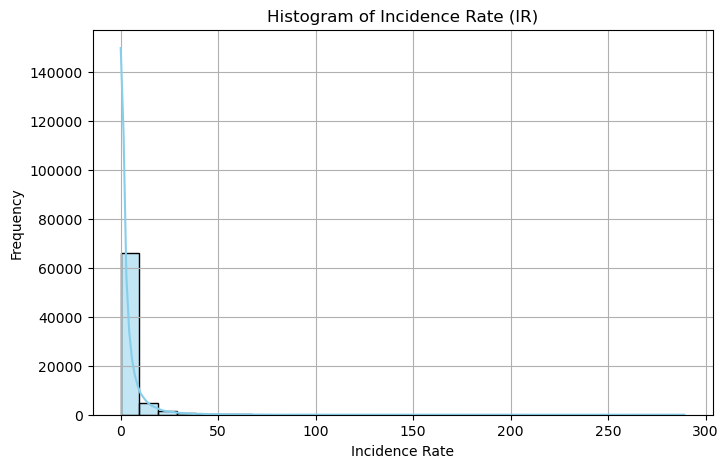

In [3]:
# Histogram of Incidence Rate (IR)
plt.figure(figsize=(8, 5))
sns.histplot(df['Incidence_Rate'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Incidence Rate (IR)')
plt.xlabel('Incidence Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

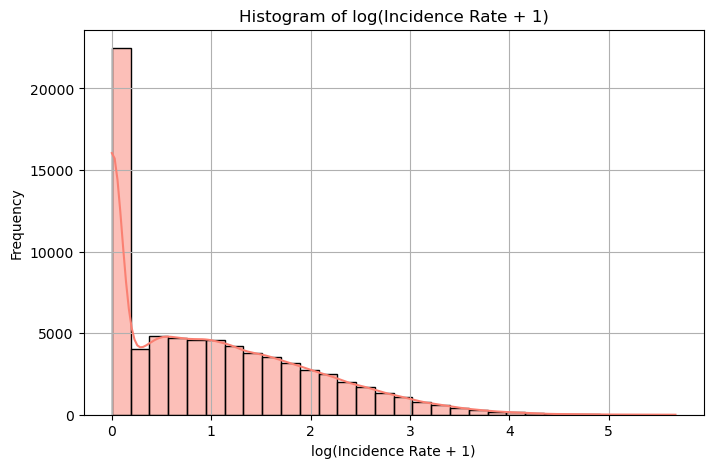

In [4]:
# Histogram of log-transformed Incidence Rate (IR)
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df['Incidence_Rate']), bins=30, kde=True, color='salmon')
plt.title('Histogram of log(Incidence Rate + 1)')
plt.xlabel('log(Incidence Rate + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

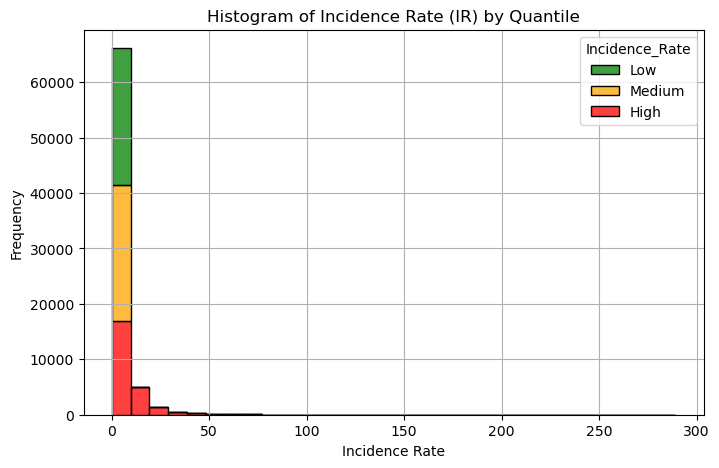

Quantile counts:
Incidence_Rate
Low       24625
Medium    24623
High      24624
Name: count, dtype: int64


In [5]:
# Histogram of Incidence Rate (IR) with quantile separation
quantiles = pd.qcut(df['Incidence_Rate'], 3, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Incidence_Rate', hue=quantiles, bins=30, palette=['green', 'orange', 'red'], multiple='stack')
plt.title('Histogram of Incidence Rate (IR) by Quantile')
plt.xlabel('Incidence Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print counts for each quantile
print('Quantile counts:')
print(quantiles.value_counts().sort_index())

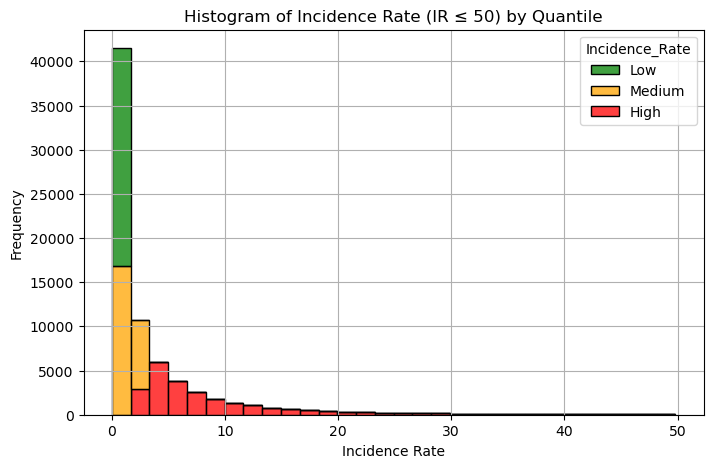

Quantile counts (all data):
Incidence_Rate
Low       24625
Medium    24623
High      24624
Name: count, dtype: int64


In [6]:
# Histogram of Incidence Rate (IR) by quantile, showing only IR <= 50
quantiles = pd.qcut(df['Incidence_Rate'], 3, labels=['Low', 'Medium', 'High'])
df_plot = df[df['Incidence_Rate'] <= 50]
quantiles_plot = quantiles[df['Incidence_Rate'] <= 50]
plt.figure(figsize=(8, 5))
sns.histplot(data=df_plot, x='Incidence_Rate', hue=quantiles_plot, bins=30, palette=['green', 'orange', 'red'], multiple='stack')
plt.title('Histogram of Incidence Rate (IR ≤ 50) by Quantile')
plt.xlabel('Incidence Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print counts for each quantile (all data)
print('Quantile counts (all data):')
print(quantiles.value_counts().sort_index())

In [7]:
# Print the value ranges for each quantile (low, medium, high)
quantile_bins = pd.qcut(df['Incidence_Rate'], 3)
labels = ['Low', 'Medium', 'High']
for i, interval in enumerate(quantile_bins.cat.categories):
    print(f"{labels[i]}: {interval.left:.2f} to {interval.right:.2f}")

Low: -0.00 to 0.34
Medium: 0.34 to 2.73
High: 2.73 to 289.14


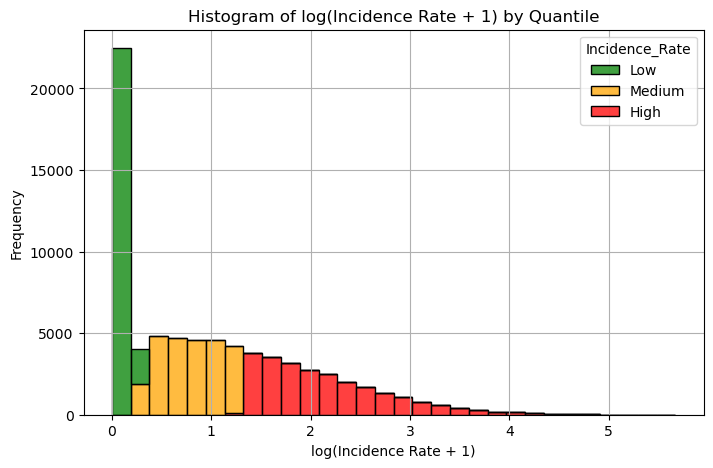

Quantile counts (log-transformed IR):
Incidence_Rate
Low       24625
Medium    24623
High      24624
Name: count, dtype: int64
Low: -0.00 to 0.29
Medium: 0.29 to 1.32
High: 1.32 to 5.67


In [8]:
# Log-transform IR, separate into three quantiles, and plot histogram
log_IR = np.log1p(df['Incidence_Rate'])
log_quantiles = pd.qcut(log_IR, 3, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8, 5))
sns.histplot(x=log_IR, hue=log_quantiles, bins=30, palette=['green', 'orange', 'red'], multiple='stack')
plt.title('Histogram of log(Incidence Rate + 1) by Quantile')
plt.xlabel('log(Incidence Rate + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print counts for each quantile
print('Quantile counts (log-transformed IR):')
print(log_quantiles.value_counts().sort_index())

# Print the value ranges for each quantile
log_quantile_bins = pd.qcut(log_IR, 3)
labels = ['Low', 'Medium', 'High']
for i, interval in enumerate(log_quantile_bins.cat.categories):
    print(f"{labels[i]}: {interval.left:.2f} to {interval.right:.2f}")

In [9]:
# Count cases above and below 2.1 per 100000 for Incidence Rate (before log transform)
threshold = 2.1
below = (df['Incidence_Rate'] < threshold).sum()
above = (df['Incidence_Rate'] >= threshold).sum()
print(f"Cases below {threshold} per 100000: {below}")
print(f"Cases above or equal to {threshold} per 100000: {above}")

Cases below 2.1 per 100000: 45104
Cases above or equal to 2.1 per 100000: 28768


In [10]:
# Count cases where Incidence Rate is below 2.1 and exactly 0
threshold = 2.1
below_mask = df['Incidence_Rate'] < threshold
zero_below = (df['Incidence_Rate'][below_mask] == 0).sum()
print(f"Cases below {threshold} per 100000 and exactly 0: {zero_below}")

Cases below 2.1 per 100000 and exactly 0: 21086


In [11]:
# Classify IR into four quantiles: Near-zero, Low-risk, Mid-risk, High-risk
classes = pd.Series(index=df.index, dtype='object')
classes[df['Incidence_Rate'] == 0] = 'Near-zero'
nonzero_mask = df['Incidence_Rate'] > 0
nonzero_IR = df.loc[nonzero_mask, 'Incidence_Rate']
nonzero_quantiles = pd.qcut(nonzero_IR, 3, labels=['Low-risk', 'Mid-risk', 'High-risk'])
classes[nonzero_mask] = nonzero_quantiles.values

# Print counts for each class
print(classes.value_counts())

# Optionally, show the value ranges for each nonzero class
quantile_bins = pd.qcut(nonzero_IR, 3)
labels = ['Low-risk', 'Mid-risk', 'High-risk']
for i, interval in enumerate(quantile_bins.cat.categories):
    print(f"{labels[i]}: {interval.left:.2f} to {interval.right:.2f}")

Near-zero    21086
Low-risk     17596
High-risk    17596
Mid-risk     17594
Name: count, dtype: int64
Low-risk: 0.02 to 1.38
Mid-risk: 1.38 to 4.34
High-risk: 4.34 to 289.14


In [12]:
# Classify IR into four quantiles based on log-transformed values
log_IR = np.log1p(df['Incidence_Rate'])
classes_log = pd.Series(index=df.index, dtype='object')
classes_log[df['Incidence_Rate'] == 0] = 'Near-zero'
nonzero_mask = df['Incidence_Rate'] > 0
nonzero_log_IR = log_IR[nonzero_mask]
nonzero_log_quantiles = pd.qcut(nonzero_log_IR, 3, labels=['Low-risk', 'Mid-risk', 'High-risk'])
classes_log[nonzero_mask] = nonzero_log_quantiles.values

# Print counts for each class
print(classes_log.value_counts())

# Show the value ranges for each nonzero class (log-transformed)
quantile_bins_log = pd.qcut(nonzero_log_IR, 3)
labels = ['Low-risk', 'Mid-risk', 'High-risk']
for i, interval in enumerate(quantile_bins_log.cat.categories):
    print(f"{labels[i]}: {interval.left:.2f} to {interval.right:.2f} (log(IR+1))")

Near-zero    21086
Low-risk     17596
High-risk    17596
Mid-risk     17594
Name: count, dtype: int64
Low-risk: 0.02 to 0.87 (log(IR+1))
Mid-risk: 0.87 to 1.68 (log(IR+1))
High-risk: 1.68 to 5.67 (log(IR+1))


In [13]:
# Add log-based class label to df and save

df['IR_class_log'] = classes_log
output_path = PROCESSED_DIR / 'monthly_dengue_env_id_with_class.csv'
df.to_csv(output_path, index=False)
print(f"Saved DataFrame with IR_class_log to {output_path}")

Saved DataFrame with IR_class_log to /home/patwuch/projects/project2/data/processed/monthly_dengue_env_id_with_class.csv


In [14]:
df

,ID_2,Region,YearMonth,Monthly_Infection,Population,Incidence_Rate,temperature_2m,temperature_2m_min,temperature_2m_max,potential_evaporation_sum,...,True_Area_Class_50,True_Area_Class_40,True_Area_Class_95,True_Area_Class_30,True_Area_Class_20,True_Area_Class_10,True_Area_Class_90,True_Area_Class_80,Region_Group,IR_class_log
0,1,Sumatra,2010-01-01,0,114852,0.000000,21.139684,18.520215,24.737291,237.207221,...,1.102676e+07,7.655062e+07,0.0,1.484174e+07,1251727.27,2.125181e+09,302177.97,8706657.69,Sumatra,Near-zero
168,2,Sumatra,2010-01-01,2,151594,1.319313,21.676474,18.802641,25.568939,227.497145,...,1.056856e+07,6.260955e+07,0.0,9.207553e+07,3866854.05,2.850946e+09,3661066.48,33005025.37,Sumatra,Low-risk
336,3,Sumatra,2010-01-01,48,299264,16.039350,24.881951,22.633740,27.681284,276.521550,...,2.262062e+07,1.437627e+08,0.0,3.665300e+08,212759.34,2.203744e+09,827921.96,44298984.54,Sumatra,High-risk
504,4,Sumatra,2010-01-01,0,66632,0.000000,23.839357,21.264055,27.290514,280.836788,...,4.746028e+06,2.516287e+07,0.0,1.081493e+08,4241318.20,3.526294e+09,4401133.20,43297505.91,Sumatra,Near-zero
672,5,Sumatra,2010-01-01,21,188909,11.116463,21.277129,18.731642,24.746705,242.563320,...,8.915484e+06,3.957018e+07,0.0,6.004788e+07,7664769.65,3.391547e+09,1323229.28,31124713.31,Sumatra,High-risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73199,440,Java,2023-12-01,31,1029997,3.009718,26.648808,23.423459,31.326640,268.582130,...,1.030722e+08,1.005271e+08,0.0,9.076198e+06,0.00,2.937075e+08,16934.32,2534007.47,Java,Mid-risk
73367,441,Java,2023-12-01,14,749274,1.868475,26.648808,23.423459,31.326640,268.582130,...,4.589681e+07,1.118960e+08,0.0,6.330359e+07,0.00,1.245872e+09,0.00,8271049.98,Java,Mid-risk
73535,442,Java,2023-12-01,25,434483,5.753965,26.648808,23.423459,31.326640,268.582130,...,2.199159e+07,9.085647e+07,0.0,1.695050e+07,166.03,4.641601e+08,16935.48,6132365.38,Java,High-risk
73703,443,Java,2023-12-01,21,1232598,1.703718,26.648808,23.423459,31.326640,268.582130,...,1.488120e+08,1.085471e+08,0.0,1.409732e+07,0.00,3.082987e+08,0.00,76258.18,Java,Mid-risk
